In [2]:
import PIL.Image
import cv2
import numpy as np
import random
import concurrent.futures

def img_to_patches(input_path:str) -> tuple:
    """
    Returns 32x32 patches of a resized 256x256 images,
    it returns 64x64 patches on grayscale and 64x64 patches
    on the RGB color scale
    --------------------------------------------------------
    ## parameters:
    - input_path: Accepts input path of the image
    """
    img = PIL.Image.open(fp=input_path)
    if(input_path[-3:]!='jpg' or input_path[-4:]!='jpeg'):
        img = img.convert('RGB')
    if(img.size!=(256,256)):
        img = img.resize(size=(256,256))
    patch_size = 32
    grayscale_imgs = []
    imgs = []
    for i in range(0,img.height,patch_size):
        for j in range(0, img.width, patch_size):
            box = (j,i,j+patch_size,i+patch_size)
            img_color = np.asarray(img.crop(box))
            grayscale_image = cv2.cvtColor(src=img_color, code=cv2.COLOR_RGB2GRAY)
            grayscale_imgs.append(grayscale_image.astype(dtype=np.int32))
            imgs.append(img_color)
    return grayscale_imgs,imgs



def get_l1(v,x,y):
    l1=0
    # 1 to m, 1 to m-1
    for i in range(0,y-1):
        for j  in range(0,x):
            l1+=abs(v[j][i]-v[j][i+1])
    return l1

def get_l2(v,x,y):
    l2=0
    # 1 to m-1, 1 to m
    for i in range(0,y):
        for j  in range(0,x-1):
            l2+=abs(v[j][i]-v[j+1][i])
    return l2

def get_l3l4(v,x,y):
    l3=l4=0
    # 1 to m-1, 1 to m-1
    for i in range(0,y-1):
        for j  in range(0,x-1):
            l3+=abs(v[j][i]-v[j+1][i+1])
            l4+=abs(v[j+1][i]-v[j][i+1])

    return l3+l4

def get_pixel_var_degree_for_patch(patch:np.array)->int:
    """
    gives pixel variation for a given patch
    ---------------------------------------
    ## parameters:
    - patch: accepts a numpy array format of the patch of an image
    """
    x,y = patch.shape
    l1=l2=l3l4=0
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
        future_l1 = executor.submit(get_l1,patch,x,y)
        future_l2 = executor.submit(get_l2,patch,x,y)
        future_l3l4 = executor.submit(get_l3l4,patch,x,y)

        l1 = future_l1.result()
        l2 = future_l2.result()
        l3l4 = future_l3l4.result()

    return  l1+l2+l3l4


def extract_rich_and_poor_textures(variance_values:list, patches:list):
    """
    returns a list of rich texture and poor texture patches respectively
    --------------------------------------------------------------------
    ## parameters:
    - variance_values: list of values that are pixel variances of each patch
    - color_patches: coloured patches of the target image
    """
    threshold = np.mean(variance_values)
    rich_texture_patches = []
    poor_texture_patches = []
    for i,j in enumerate(variance_values):
        if j >= threshold:
            rich_texture_patches.append(patches[i])
        else:
            poor_texture_patches.append(patches[i])
    
    return rich_texture_patches, poor_texture_patches



def get_complete_image(patches:list, coloured=True):
    """
    Develops complete 265x256 image from rich and poor texture patches
    ------------------------------------------------------------------
    ## parameters:
    - patches: Takes a list of rich or poor texture patches
    """
    random.shuffle(patches)
    p_len = len(patches)
    while len(patches)<64:
        patches.append(patches[random.randint(0, p_len-1)])
    
    if(coloured==True):
        grid = np.asarray(patches).reshape((8,8,32,32,3))
    else:
        grid = np.asarray(patches).reshape((8,8,32,32))


    # joins columns to only leave rows
    rows = [np.concatenate(grid[i,:], axis=1) for i in range(8)]

    # joins the rows to create the final image
    img = np.concatenate(rows,axis=0)

    return img
    


def smash_n_reconstruct(input_path:str, coloured=True):
    """
    Performs the SmashnReconstruct part of preprocesing
    reference: [link](https://arxiv.org/abs/2311.12397)

    return rich_texture,poor_texture
    
    ----------------------------------------------------
    ## parameters:
    - input_path: Accepts input path of the image
    """
    gray_scale_patches, color_patches = img_to_patches(input_path=input_path)
    pixel_var_degree = []
    for patch in gray_scale_patches:
        pixel_var_degree.append(get_pixel_var_degree_for_patch(patch))
    
    # r_patch = list of rich texture patches, p_patch = list of poor texture patches
    if(coloured):
        r_patch,p_patch = extract_rich_and_poor_textures(variance_values=pixel_var_degree,patches=color_patches)
    else:
        r_patch,p_patch = extract_rich_and_poor_textures(variance_values=pixel_var_degree,patches=gray_scale_patches)
    rich_texture,poor_texture = None,None

    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        rich_texture_future = executor.submit(get_complete_image,r_patch,coloured)
        poor_texture_future = executor.submit(get_complete_image,p_patch,coloured)

        rich_texture = rich_texture_future.result()
        poor_texture = poor_texture_future.result()

    return rich_texture, poor_texture

if __name__=="main":
    smash_n_reconstruct(input_path="placeholder")

In [3]:
import numpy as np
import cv2
from scipy.ndimage import rotate

def apply_filter_a(src:np.ndarray):
    src_copy = np.copy(src)
    f1 = np.array([[[ 0,  0,  0,  0,  0],
        [ 0,  1,  0,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  1,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0, -1,  1,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  0,  1,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  1, -1,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]]])
    
    img = cv2.filter2D(src=src_copy, kernel=f1[0], ddepth=-1)
    for filter in f1[1:]:
        img = cv2.add(img,cv2.filter2D(src=src_copy, kernel=filter, ddepth=-1))

    return img//8

def apply_filter_b(src:np.ndarray):
    src_copy = np.copy(src)
    f2 = np.array([[[ 0,  0,  0,  0,  0],
                    [ 0,  2,  1,  0,  0],
                    [ 0,  1, -3,  0,  0],
                    [ 0,  0,  0,  1,  0],
                    [ 0,  0,  0,  0,  0]],

                    [[ 0,  0, -1,  0,  0],
                    [ 0,  0,  3,  0,  0],
                    [ 0,  0, -3,  0,  0],
                    [ 0,  0,  1,  0,  0],
                    [ 0,  0,  0,  0,  0]],

                    [[ 0,  0,  0,  0,  0],
                    [ 0,  0,  1,  2,  0],
                    [ 0,  0, -3,  1,  0],
                    [ 0,  1,  0,  0,  0],
                    [ 0,  0,  0,  0,  0]],

                    [[ 0,  0,  0,  0,  0],
                    [ 0,  0,  0,  0,  0],
                    [ 0,  1, -3,  3, -1],
                    [ 0,  0,  0,  0,  0],
                    [ 0,  0,  0,  0,  0]],

                    [[ 0,  0,  0,  0,  0],
                    [ 0,  1,  0,  0,  0],
                    [ 0,  0, -3,  1,  0],
                    [ 0,  0,  1,  2,  0],
                    [ 0,  0,  0,  0,  0]],

                    [[ 0,  0,  0,  0,  0],
                    [ 0,  0,  1,  0,  0],
                    [ 0,  0, -3,  0,  0],
                    [ 0,  0,  3,  0,  0],
                    [ 0,  0, -1,  0,  0]],

                    [[ 0,  0,  0,  0,  0],
                    [ 0,  0,  0,  1,  0],
                    [ 0,  1, -3,  0,  0],
                    [ 0,  2,  1,  0,  0],
                    [ 0,  0,  0,  0,  0]],

                    [[ 0,  0,  0,  0,  0],
                    [ 0,  0,  0,  0,  0],
                    [-1,  3, -3,  1,  0],
                    [ 0,  0,  0,  0,  0],
                    [ 0,  0,  0,  0,  0]]])

    img = cv2.filter2D(src=src_copy, kernel=f2[0], ddepth=-1)
    for filter in f2[1:]:
        img = cv2.add(img,cv2.filter2D(src=src_copy, kernel=filter, ddepth=-1))

    return img//8



def apply_filter_c(src:np.ndarray):
    src_copy=np.copy(src)
    f3 = np.array([[[ 0,  0,  0,  0,  0],
                    [ 0,  0,  1,  0,  0],
                    [ 0,  0, -2,  0,  0],
                    [ 0,  0,  1,  0,  0],
                    [ 0,  0,  0,  0,  0]],

                    [[ 0,  0,  0,  0,  0],
                    [ 0,  0,  0,  0,  0],
                    [ 0,  1, -2,  1,  0],
                    [ 0,  0,  0,  0,  0],
                    [ 0,  0,  0,  0,  0]],

                    [[ 0,  0,  0,  0,  0],
                    [ 0,  1,  0,  0,  0],
                    [ 0,  0, -2,  0,  0],
                    [ 0,  0,  0,  1,  0],
                    [ 0,  0,  0,  0,  0]],

                    [[ 0,  0,  0,  0,  0],
                    [ 0,  0,  0,  1,  0],
                    [ 0,  0, -2,  0,  0],
                    [ 0,  1,  0,  0,  0],
                    [ 0,  0,  0,  0,  0]]])
    
    img = cv2.filter2D(src=src_copy, kernel=f3[0], ddepth=-1)
    for filter in f3[1:]:
        img = cv2.add(img,cv2.filter2D(src=src_copy, kernel=filter, ddepth=-1))

    return img//4


def apply_filter_d(src:np.ndarray):
    src_copy=np.copy(src)
    f4 = np.array([[[ 0,  0,  0,  0,  0],
                    [ 0, -1,  2, -1,  0],
                    [ 0,  2, -4,  2,  0],
                    [ 0,  0,  0,  0,  0],
                    [ 0,  0,  0,  0,  0]],

                    [[ 0,  0,  0,  0,  0],
                    [ 0, -1,  2,  0,  0],
                    [ 0,  2, -4,  0,  0],
                    [ 0, -1,  2,  0,  0],
                    [ 0,  0,  0,  0,  0]],

                    [[ 0,  0,  0,  0,  0],
                    [ 0,  0,  0,  0,  0],
                    [ 0,  2, -4,  2,  0],
                    [ 0, -1,  2, -1,  0],
                    [ 0,  0,  0,  0,  0]],

                    [[ 0,  0,  0,  0,  0],
                    [ 0,  0,  2, -1,  0],
                    [ 0,  0, -4,  2,  0],
                    [ 0,  0,  2, -1,  0],
                    [ 0,  0,  0,  0,  0]]])

    img = cv2.filter2D(src=src_copy, kernel=f4[0], ddepth=-1)
    for filter in f4[1:]:
        img = cv2.add(img,cv2.filter2D(src=src_copy, kernel=filter, ddepth=-1))

    return img//4

def apply_filter_e(src:np.ndarray):
    src_copy=np.copy(src)
    f5 = np.array([[[  1,   2,  -2,   2,   1],
                    [  2,  -6,   8,  -6,   2],
                    [ -2,   8, -12,   8,  -2],
                    [  0,   0,   0,   0,   0],
                    [  0,   0,   0,   0,   0]],

                [[  1,   2,  -2,   0,   0],
                    [  2,  -6,   8,   0,   0],
                    [ -2,   8, -12,   0,   0],
                    [  2,  -6,   8,   0,   0],
                    [  1,   2,  -2,   0,   0]],

                [[  0,   0,   0,   0,   0],
                    [  0,   0,   0,   0,   0],
                    [ -2,   8, -12,   8,  -2],
                    [  2,  -6,   8,  -6,   2],
                    [  1,   2,  -2,   2,   1]],

                [[  0,   0,  -2,   2,   1],
                    [  0,   0,   8,  -6,   2],
                    [  0,   0, -12,   8,  -2],
                    [  0,   0,   8,  -6,   2],
                    [  0,   0,  -2,   2,   1]]])
    
    img = cv2.filter2D(src=src_copy, kernel=f5[0], ddepth=-1)
    for filter in f5[1:]:
        img=cv2.add(img,cv2.filter2D(src=src_copy, kernel=filter, ddepth=-1))

    return img//4

def apply_filter_f(src:np.ndarray):
    src_copy=np.copy(src)
    f5 = np.asarray([[ 0,  0,  0,  0,  0],
                    [ 0,  -1,  2, -1,  0],
                    [ 0,  2,  -4,  2,  0],
                    [ 0,  -1,  2, -1,  0],
                    [ 0,  0,  0,  0,  0]])
    
    img = cv2.filter2D(src=src_copy, kernel=f5, ddepth=-1)
    return img


def apply_filter_g(src:np.ndarray):
    src_copy=np.copy(src)
    f5 = np.asarray([[ -1,   2,  -2,   2,  -1],
                    [  2,  -6,   8,  -6,   2],
                    [ -2,   8, -12,   8,  -2],
                    [  2,  -6,   8,  -6,   2],
                    [ -1,   2,  -2,   2,  -1]])
    
    img = cv2.filter2D(src=src_copy, kernel=f5, ddepth=-1)
    return img

def apply_all_filters(src:np.ndarray):
    src_copy = np.copy(src)
    img = np.array(cv2.cvtColor((apply_filter_a(src_copy) + apply_filter_b(src_copy) + apply_filter_c(src_copy) + \
            apply_filter_d(src_copy) + apply_filter_e(src_copy) + apply_filter_f(src_copy) + apply_filter_g(src_copy)), cv2.COLOR_RGB2GRAY)//7)
    img_thresh = np.median(img)+2
    return cv2.threshold(img,img_thresh,255,cv2.THRESH_BINARY)[1]

In [4]:
import tensorflow as tf
from keras import layers,Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

In [5]:
@tf.function
def hard_tanh(x):
    return tf.maximum(tf.minimum(x, 1), -1)

class featureExtractionLayer(layers.Layer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')
        self.bn = layers.BatchNormalization()
        self.activation = layers.Lambda(hard_tanh)
        
    
    def call(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.activation(x)
        return x

In [6]:
input1 = layers.Input(shape=(256,256,1),name="rich_texture")
input2 = layers.Input(shape=(256,256,1),name="poor_texture")

l1 = featureExtractionLayer(name="feature_extraction_layer_rich_texture")(input1)
l2 = featureExtractionLayer(name="feature_extraction_layer_poor_texture")(input2)

contrast = layers.subtract((l1,l2))

x = layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu')(contrast)
x = layers.BatchNormalization()(x)
for i in range(3):
    x = layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu')(x)
    x = layers.BatchNormalization()(x)
x = layers.BatchNormalization()(x)

for i in range(4):
    x = layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu')(x)
    x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(3,3)(x)

for i in range(2):
    x = layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu')(x)
    x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(3,3)(x)

for i in range(2):
    x = layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu')(x)
    x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(inputs=(input1,input2), outputs=x, name="rich_texture_poor_texture_contrast")
model.compile(
                optimizer='adam',
                loss='BinaryCrossentropy',
                metrics=['binary_accuracy']
            )
model.summary()

Model: "rich_texture_poor_texture_contrast"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rich_texture        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ poor_texture        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extraction… │ (None, 254, 254,  │        448 │ rich_texture[0][… │
│ (featureExtraction… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extraction… │ (None, 254, 254,  │        448 │ poor_texture[0][… │
│ (featureExtraction… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 254, 254,  │          0 │ feature_extracti… │
│                     │ 32)               │            │ feature_extracti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 252, 252,  │      9,248 │ subtract[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 252, 252,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 250, 250,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 250,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 248, 248,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 248, 248,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 246, 246,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 246, 246,  │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 246, 246,  │        128 │ batch_normalizat… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 244, 244,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 244, 244,  │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 242, 242,  │      9,248 │ batch_normalizat

 Total params: 113,569 (443.63 KB)

 Trainable params: 112,609 (439.88 KB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
# history = model.fit(dataset,
#                     epochs=20,
#                     batch_size=64,
#                     validation_data=validation_set,
#                     callbacks=[checkpoint_callback, early_stopping_callback]
#                    )

# Testing

In [8]:
def preprocess_image(path):
    # Convert path to string if it's a tensor
    path = path.numpy().decode('utf-8') if tf.is_tensor(path) else path
    
    try:
        # Perform preprocessing
        rt, pt = smash_n_reconstruct(path)

        plt.subplot(1,2,1)
        plt.imshow(rt)
        plt.title('rich texture - AI generated image')
        plt.subplot(1,2,2)
        plt.imshow(pt)
        plt.title('poor texture - AI generated')
        plt.show()
        
        rt = apply_all_filters(rt)
        pt = apply_all_filters(pt)
        plt.subplot(1,2,1)
        plt.imshow(rt, cmap = 'gray')
        plt.title('rich texture - AI generated image')
        plt.subplot(1,2,2)
        plt.imshow(pt, cmap = 'gray')
        plt.title('poor texture - AI generated')
        plt.show()

        rt, pt = smash_n_reconstruct(path)
        
        # Apply filters and ensure consistent shape
        frt = tf.cast(tf.expand_dims(apply_all_filters(rt), axis=-1), dtype=tf.float64)
        fpt = tf.cast(tf.expand_dims(apply_all_filters(pt), axis=-1), dtype=tf.float64)
        
        # Ensure shape
        frt = tf.ensure_shape(frt, [256, 256, 1])
        fpt = tf.ensure_shape(fpt, [256, 256, 1])
        
        # Add batch dimension, so shape becomes [1, 256, 256, 1]
        frt = tf.expand_dims(frt, axis=0)
        fpt = tf.expand_dims(fpt, axis=0)
        
        return frt, fpt
        
    except Exception as e:
        print(f"Error processing {path}: {e}")
        # Return dummy tensors to avoid breaking the pipeline
        dummy = tf.zeros([256, 256, 1], dtype=tf.float32)
        return dummy, dummy


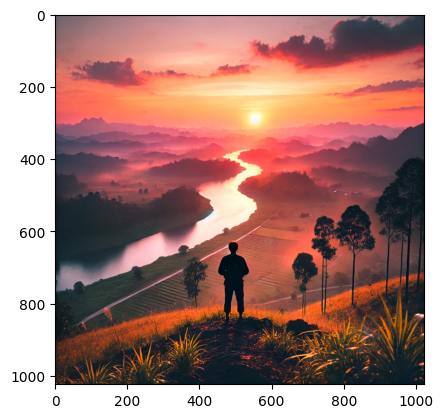

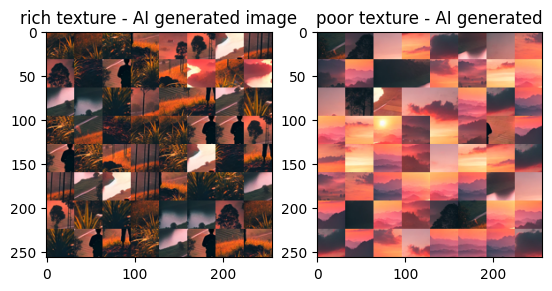

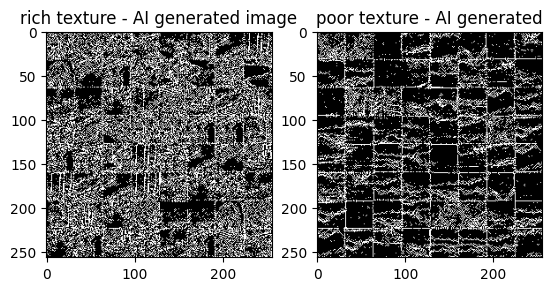

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0.79181594]]
Fake


In [16]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2 
import keras
import matplotlib.pyplot as plt
# or other image loading libraries


# Register the custom layer with Keras
keras.utils.get_custom_objects()['featureExtractionLayer'] = featureExtractionLayer

# Load the trained model from the .h5 file
model = load_model('/kaggle/input/artistic_image_real_fake_classifier/keras/default/1/classifier_artistic.keras')

# Example test data
test_image_path = '/kaggle/input/chat-gpt-test/test.webp'

# Display image
image = cv2.imread(test_image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# preprocess image
test_frt, test_fpt = preprocess_image(test_image_path)

# Make a prediction
predictions = model.predict([test_frt, test_fpt])
print(predictions)

if predictions > 0.5:
    print("Fake")
else:
    print("Real")